# Análise de Elementos nutricionais em FastFoods

*Redução de dimensionalidade* ou *redução de dimensão* é uma técnica usada em mineração de dados e aprendizado de máquina que tem como objetivo a redução do número de variáveis de entrada para extrair um conjunto de variáveis principais. Apesar do risco de perda de acurácia na análise, a redução do tempo de processamento torna esta técnca importante para a análise de dados multivariáveis. 

Os algoritmos de seleção de atributos tentam encontrar um subconjunto das variáveis de entrada (também chamadas de atributos) mais importante para a análise. A análise de dados como regressão ou classificação pode ser feita no espaço reduzido com mais velocidade e precisão do que no espaço original.

## Singular Value Decomposition (SVD)

A decomposição de valor singular, ou Singular Value Decomposition (SVD), é uma técnica de álgebra linear onde uma matriz A é transformada por fatoração em um produto de três matrizes A = UDV', onde as colunas de U e V' são ortonormais e a matriz D é diagonal com números reais positivas. O SVD é útil em várias tarefas, dentre elas, pode ser usada na redução de dimensionalidade. Diferentemente da decomposição espectral, comumente usada em Álgebra Linear, a decomposição de valor singular pode ser usada para todas as matrizes (retangulares ou quadradas), sendo uma ferramenta útil para análise de dados. A matriz diagonal D representa a relevância de cada atributo e através da seleção dos maiores valores podemos excluir linhas da matrz U e colunas da matriz V', reduzindo a dimensionalidade da matriz.

## Principal Component Analysis (PCA)

A principal técnica linear para redução de dimensionalidade é a análise de componentes principais (PCA). PCA realiza um mapeamento linear dos dados de entrada para um espaço de menor dimensão, de forma que a variação dos dados na representação de dimensão menor seja maximizada. Na prática, a matriz de covariância (e às vezes a de correlação) dos dados é construída e são calculados os autovetores nessa matriz. Os vetores próprios que correspondem aos maiores valores próprios (os componentes principais) que agora podem ser usados para reconstruir uma grande parte da variação dos dados originais. Além disso, os primeiros autovetores podem ser interpretados como termos do comportamento físico do sistema, porque geralmente contribuem com a maior parte da energia do sistema. Uma redução usando o PCA deve ser comprovada caso a caso, pois nem todos os sistemas exibem esse comportamento de equivalencia. O espaço original foi reduzido com perda de dados, mas esperamos manter a variação mais importante para a análise do problema.

## Exemplo

Este exemplo apresenta a redução de dimensionalidade usando SVD e PCA sobre dados nutricionais de alimentos da USDA National Nutrient Database com 45 campos. O objetivo é obter relações dos alimentos através apenas dos principais componente.

In [137]:
# Carregando bibliotecas
import pyspark
import time
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import functions as F

from pyspark.ml.feature import VectorSlicer
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA

from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.mllib.linalg.distributed import SingularValueDecomposition

# Mostrar Gráficos em linha
%matplotlib inline
# Gravar tempo inicial
start_time = time.time()

# Number of principal components
kComp = 8

# Number of components (collumn)
TotalComp = 14

# Set principal component column label
colname = [] 
for i in range(1, kComp+1):
    colname.append("PC"+str(i))

In [138]:
# Criando a sessão do Spark
spark = SparkSession.builder\
.master("local[*]")\
.appName("ReducaoFastFood")\
.getOrCreate()


In [139]:
# Definindo o schema do nosso DataFrame
fast_food_schema = StructType([
    StructField('restaurant', StringType(), True),
    StructField('item', StringType(), True),
    StructField('calories', IntegerType(), True),
    StructField('cal_fat', IntegerType(), True),
    StructField('total_fat', IntegerType(), True),
    StructField('sat_fat', FloatType(), True),
    StructField('trans_fat', FloatType(), True),
    StructField('cholesterol', IntegerType(), True),
    StructField('sodium', IntegerType(), True),
    StructField('total_carb', IntegerType(), True),
    StructField('fiber', IntegerType(), True),
    StructField('sugar', IntegerType(), True),
    StructField('protein', IntegerType(), True),
    StructField('vit_a', IntegerType(), True),
    StructField('vit_c', IntegerType(), True),
    StructField('calcium', IntegerType(), True),
    StructField('salad', StringType(), True),
]) 

In [140]:
# Extraindo dados da tabela para o DataFrame do Spark
data_path = "fastfood.csv"
fast_food = spark.read.format("csv").options(header='true'). \
            load(data_path, schema=fast_food_schema)
#food.types
fast_food.show(20)

+----------+--------------------+--------+-------+---------+-------+---------+-----------+------+----------+-----+-----+-------+-----+-----+-------+-----+
|restaurant|                item|calories|cal_fat|total_fat|sat_fat|trans_fat|cholesterol|sodium|total_carb|fiber|sugar|protein|vit_a|vit_c|calcium|salad|
+----------+--------------------+--------+-------+---------+-------+---------+-----------+------+----------+-----+-----+-------+-----+-----+-------+-----+
| Mcdonalds|Artisan Grilled C...|     380|     60|        7|    2.0|      0.0|         95|  1110|        44|    3|   11|     37|    4|   20|     20|Other|
| Mcdonalds|Single Bacon Smok...|     840|    410|       45|   17.0|      1.5|        130|  1580|        62|    2|   18|     46|    6|   20|     20|Other|
| Mcdonalds|Double Bacon Smok...|    1130|    600|       67|   27.0|      3.0|        220|  1920|        63|    3|   18|     70|   10|   20|     50|Other|
| Mcdonalds|Grilled Bacon Smo...|     750|    280|       31|   10.0|  

In [141]:
# Tratando parametros para converter colunas da tabela em vetores

# lista de colunas com dados não-relevantes para a análise, iremos removê-las.
avoid =  ["salad", "restaurant", "item"]

# lista das nossas colunas referência utilizadas posteriormente para reverter o vetor.
list = [ x for x in fast_food.columns if x not in avoid]


assembler = VectorAssembler(
                inputCols=list,
                outputCol="values")

# Cria a tabela final de dados com seus respectivos nomes de colunas correspondentes ao vetor gerado,
# adicionando novamente algumas das colunas removidas para correlacionar,
# porém  retirando o que poderia ser redundante como a coluna salad que continha valores desconexos.
data = (assembler.setHandleInvalid("skip").transform(fast_food).select("restaurant","item", "values"))
print("Tabela final reduzida:")
data.printSchema()
data.show()


Tabela final reduzida:
root
 |-- restaurant: string (nullable = true)
 |-- item: string (nullable = true)
 |-- values: vector (nullable = true)

+----------+--------------------+--------------------+
|restaurant|                item|              values|
+----------+--------------------+--------------------+
| Mcdonalds|Artisan Grilled C...|[380.0,60.0,7.0,2...|
| Mcdonalds|Single Bacon Smok...|[840.0,410.0,45.0...|
| Mcdonalds|Double Bacon Smok...|[1130.0,600.0,67....|
| Mcdonalds|Grilled Bacon Smo...|[750.0,280.0,31.0...|
| Mcdonalds|Crispy Bacon Smok...|[920.0,410.0,45.0...|
| Mcdonalds|             Big Mac|[540.0,250.0,28.0...|
| Mcdonalds|        Cheeseburger|[300.0,100.0,12.0...|
| Mcdonalds|Classic Chicken S...|[510.0,210.0,24.0...|
| Mcdonalds| Double Cheeseburger|[430.0,190.0,21.0...|
| Mcdonalds|Double Quarter Po...|[770.0,400.0,45.0...|
| Mcdonalds|       Filet-O-Fish®|[380.0,170.0,18.0...|
| Mcdonalds|Garlic White Ched...|[620.0,300.0,34.0...|
| Mcdonalds|Grilled Garlic Wh.

In [142]:
# Os valores do vetor possuem escalas diferentes, então vamos precisar normalizar as colunas
# Para adequar os valores e associar eles de maneira escalonada iremos usar a seguinte função
standardScaler = StandardScaler(inputCol="values", outputCol="scalled_values", withStd=True, withMean=True)
scalledmodel = standardScaler.fit(data)

# Removeremos agora a coluna não-escalonada, pois ela não tem mais utilidade.
new_scalled_data = scalledmodel.transform(data).drop("values")

new_scalled_data.printSchema()
new_scalled_data.show()

root
 |-- restaurant: string (nullable = true)
 |-- item: string (nullable = true)
 |-- scalled_values: vector (nullable = true)

+----------+--------------------+--------------------+
|restaurant|                item|      scalled_values|
+----------+--------------------+--------------------+
| Mcdonalds|Artisan Grilled C...|[-0.5264572657437...|
| Mcdonalds|Single Bacon Smok...|[1.01593107566295...|
| Mcdonalds|Double Bacon Smok...|[1.98830633437588...|
| Mcdonalds|Grilled Bacon Smo...|[0.71415944364859...|
| Mcdonalds|Crispy Bacon Smok...|[1.28417252634238...|
| Mcdonalds|             Big Mac|[0.01002563561509...|
| Mcdonalds|        Cheeseburger|[-0.7946987164231...|
| Mcdonalds|Classic Chicken S...|[-0.0905649083896...|
| Mcdonalds| Double Cheeseburger|[-0.3588063590691...|
| Mcdonalds|Double Quarter Po...|[0.78121980631845...|
| Mcdonalds|       Filet-O-Fish®|[-0.5264572657437...|
| Mcdonalds|Garlic White Ched...|[0.27826708629452...|
| Mcdonalds|Grilled Garlic Wh...|[-0.02350454

## Utilizando os valores escalonados

A partir daqui iremos utilizar os dois métodos para trabalhar com os valores escalonados obtidos




## SVD
Testando os valores escalonados com uma redução SVD

In [143]:
# registrando tempo de execução para ter o valor depois
start_time_svd = time.time()

# Percorrendo as linhas dos nossos valores escalonados para gerar uma matriz
mat = RowMatrix(new_scalled_data.rdd.map(lambda v: Vectors.fromML(v.scalled_values)))

# Contabilizar a quantidade de k -> Componentes encontrados e seus valores únicos correspondentes nos respectivos vetores
svd_model = mat.computeSVD(kComp, computeU=True)

U = svd_model.U # linhas da matriz U.
s = svd_model.s # valores de relevância para cada componente encontrada, também pode ser representada por : uma matriz diagonal retangular com números reais não negativos na diagonal
V = svd_model.V # matriz densa local

# amostras de valores encontrados para U
collected = U.rows.take(8)

print("Conjunto referente ao fator U:")
for vector in collected:
    print(vector)

print()
print("Vetor de valores únicos referentes ao fator s: %s" % s)
val_s = sum(s)

print("Conjunto referente ao fator V:\n%s" % V)

Conjunto referente ao fator U:
[0.02627678099337144,0.014101737916536515,-0.034616072372059256,0.04616505156302954,0.03680587102125548,0.027609382451759618,-0.07482868894958657,-0.07236590341792393]
[-0.06486090667890371,-0.0359566408590611,0.0013904442635983712,0.0019014473874791648,0.09748656180167886,0.026058822896193393,0.022548755398257465,0.024907376418845974]
[-0.14245194089900792,-0.06609608134430535,0.05813917492789101,-0.05783551175455166,0.10602354984788008,0.0369997313003958,-0.02848198826468687,-0.04278069269211017]
[-0.04674651335000374,-0.0017150514759279212,-0.025010323786503773,0.07693270837361836,0.0723863968423955,0.02739148762003104,-0.060914607790142905,-0.013397019061540016]
[-0.06315760082291073,0.008173681838684908,-0.037725896362521334,0.04457012687387734,0.04069151495272295,-0.0019015734339066868,0.03338311725212666,0.05702695534319157]
[-0.001327793796557648,-0.03498852589761148,-0.010185982581323624,-0.022954431321390606,0.03788048255998962,-0.00571627959963

In [144]:
rows = V.toArray().tolist()
# Utilizando pandas para melhorar a visualização dos dados
svd_comp = pd.DataFrame(rows, columns = colname, index = list)
print(svd_comp)

time_svd = time.time() - start_time_svd

                  PC1       PC2       PC3       PC4       PC5       PC6  \
calories    -0.374610  0.036011 -0.080496  0.052214 -0.101805 -0.044099   
cal_fat     -0.352885 -0.181910  0.045891  0.020996 -0.140359 -0.027686   
total_fat   -0.353623 -0.180635  0.047015  0.019301 -0.139199 -0.023364   
sat_fat     -0.308940 -0.216728  0.213774 -0.332017  0.105797  0.011432   
trans_fat   -0.230007 -0.292278  0.229132 -0.404606  0.307415  0.145606   
cholesterol -0.337669 -0.148146  0.115247  0.242380  0.064693  0.091930   
sodium      -0.323175  0.128070 -0.163635  0.284457 -0.166775 -0.053914   
total_carb  -0.255438  0.353805 -0.303749 -0.090269 -0.029714 -0.151063   
fiber       -0.109506  0.514107  0.055907 -0.193675 -0.280778 -0.019458   
sugar       -0.160459  0.319686 -0.131539  0.168847  0.851644 -0.079907   
protein     -0.338637  0.037093  0.024514  0.309539 -0.076317  0.062379   
vit_a        0.049761  0.132406  0.715718  0.218282  0.008862 -0.623802   
vit_c       -0.009225  0.

In [145]:
# Calcular a soma total dos valores singulares para mostrar a importância de cada componente
svdmodel = mat.computeSVD(TotalComp, computeU=True)
total_s = sum(svdmodel.s)    
exvar_svd = val_s / total_s

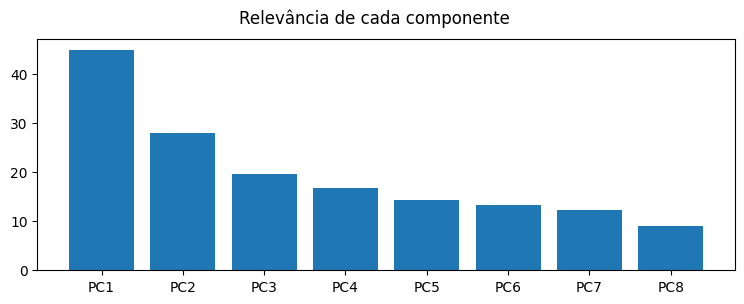

In [146]:
names = colname
values = s

fig, ax = plt.subplots(figsize=(9, 3), sharey=True)
ax.bar(names, values)
fig.suptitle('Relevância de cada componente')
plt.show()

##  PCA
Testando os valores escalonados com uma redução PCA

In [147]:
# registrando tempo de execução para ter o valor depois
start_time_pca =  time.time()

# k = número de componentes a serem reduzidas, O PCA encontra os k componentes mais importantes
pca = PCA(k=kComp, inputCol="scalled_values", outputCol="pca_values")
pcamodel = pca.fit(new_scalled_data)
result = pcamodel.transform(new_scalled_data)

result.printSchema()

root
 |-- restaurant: string (nullable = true)
 |-- item: string (nullable = true)
 |-- scalled_values: vector (nullable = true)
 |-- pca_values: vector (nullable = true)



Relevância de cada componente
[47.91796791 18.62433881  9.20865781  6.7689519   4.85853058  4.15456515
  3.55574501  1.91812802]


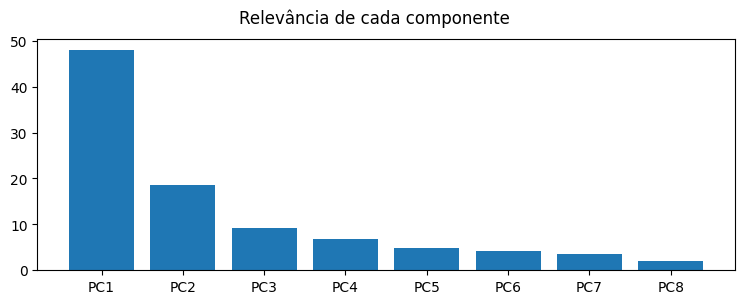

In [148]:
# Mostrando a importância de cada componente: Variância explicada
pca_var= np.round(100.00*pcamodel.explainedVariance.toArray(),kComp)
exvar_pca = sum(pcamodel.explainedVariance)

print("Relevância de cada componente")
print(pca_var)

names = colname
values = pca_var

fig, ax = plt.subplots(figsize=(9, 3), sharey=True)
ax.bar(names, values)
fig.suptitle('Relevância de cada componente')
plt.show()

In [149]:
# List the relevance of each components by element
pcs = np.round(pcamodel.pc.toArray(),4)
# Utilizando pandas para melhorar a visualização dos dados
pca_comp = pd.DataFrame(pcs, columns = colname, index = list)

print(pca_comp)

                PC1     PC2     PC3     PC4     PC5     PC6     PC7     PC8
calories    -0.3746  0.0360 -0.0805  0.0522 -0.1018 -0.0441  0.1034  0.0207
cal_fat     -0.3529 -0.1819  0.0459  0.0210 -0.1404 -0.0277  0.1727  0.3503
total_fat   -0.3536 -0.1806  0.0470  0.0193 -0.1392 -0.0234  0.1725  0.3311
sat_fat     -0.3089 -0.2167  0.2138 -0.3320  0.1058  0.0114  0.0637  0.1999
trans_fat   -0.2300 -0.2923  0.2291 -0.4046  0.3074  0.1456  0.2405 -0.5146
cholesterol -0.3377 -0.1481  0.1152  0.2424  0.0647  0.0919 -0.3452 -0.2091
sodium      -0.3232  0.1281 -0.1636  0.2845 -0.1668 -0.0539 -0.0340  0.0234
total_carb  -0.2554  0.3538 -0.3037 -0.0903 -0.0297 -0.1511  0.2912 -0.0203
fiber       -0.1095  0.5141  0.0559 -0.1937 -0.2808 -0.0195  0.3303 -0.3757
sugar       -0.1605  0.3197 -0.1315  0.1688  0.8516 -0.0799  0.0483  0.1479
protein     -0.3386  0.0371  0.0245  0.3095 -0.0763  0.0624 -0.3752 -0.4066
vit_a        0.0498  0.1324  0.7157  0.2183  0.0089 -0.6238  0.0710 -0.0009
vit_c       

In [150]:
# Listando valores do PCA para cada tipo de comida (item)
result_pca = result.select("item","pca_values")

result_pca.show(truncate=False, n=100)
time_pca = time.time() - start_time_pca

+-------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|item                                             |pca_values                                                                                                                                                            |
+-------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Artisan Grilled Chicken Sandwich                 |[1.1788159481341611,0.3944007353733108,-0.6807703036542899,0.7783925742724711,0.5257680790499395,0.3647070217027599,-0.9144460452877392,-0.6495273284120207]          |
|Single Bacon Smokehouse Burger                   |[-2.909757904623884,-1.005643820662551,0.027344903643899892,0.03206045431

In [151]:
# Listando valores do PCA por rede de fastfood (restaurant)
result_pca = result.select("restaurant","pca_values")
# Abririamos a possibilidade de analisar a relevância de cada componente 
# por rede de fastfood sem considerar o tipo de comida
result_pca.show(truncate=False, n=100)
time_pca = time.time() - start_time_pca

+-----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|restaurant |pca_values                                                                                                                                                            |
+-----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Mcdonalds  |[1.1788159481341611,0.3944007353733108,-0.6807703036542899,0.7783925742724711,0.5257680790499395,0.3647070217027599,-0.9144460452877392,-0.6495273284120207]          |
|Mcdonalds  |[-2.909757904623884,-1.005643820662551,0.027344903643899892,0.03206045431927802,1.3925855008852248,0.34422485559596244,0.2755576836845075,0.22355862220989925]        |
|Mcdonalds  |[-6.3906084925994575,-1.848590807869076,1.1433828582418035,-0.9751691237153021,1.5

## Resultados do comparativo

In [152]:
print("======================================================================================================================")
print("======================== Comparativo da Variância explicada e Tempo de cada um =======================================")
print()
print("Singular Value Decomposition (SVD):  Representatividade = %3.2f %%   Tempo Gasto = %3.3f s" % (exvar_svd*100, time_svd))
print("Principal Component Analysis (PCA):  Representatividade = %3.2f %%   Tempo Gasto = %3.3f s" % (exvar_pca*100, time_pca))
print("======================================================================================================================")

======================== Comparativo da Variância explicada e Tempo de cada um =======================================

Singular Value Decomposition (SVD):  Representatividade = 86.95 %   Tempo Gasto = 1.226 s
Principal Component Analysis (PCA):  Representatividade = 97.01 %   Tempo Gasto = 0.414 s


In [153]:
spark.stop()